In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import set_random_seed
from keras.utils import plot_model
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import Image
import graphviz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import os

Количество изображений: 10000


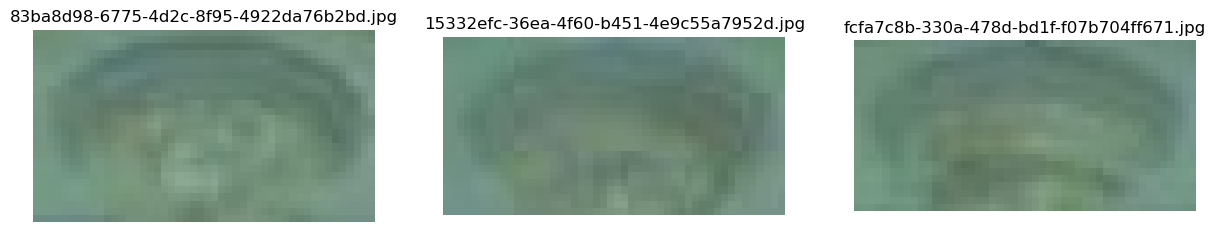

In [2]:
# Устанавливаем случайное зерно для воспроизводимости
set_random_seed(42)

img_dir = "dataset/train/"
img_paths = [os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]
print(f"Количество изображений: {len(img_paths)}")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for ax, img_path in zip(axes, img_paths[:3]): 
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Преобразование из BGR в RGB
    ax.set_title(os.path.basename(img_path))
    ax.axis('off')

plt.show()

Количество батчей в обучающем датасете: 32
Количество батчей в тестовом датасете: 8


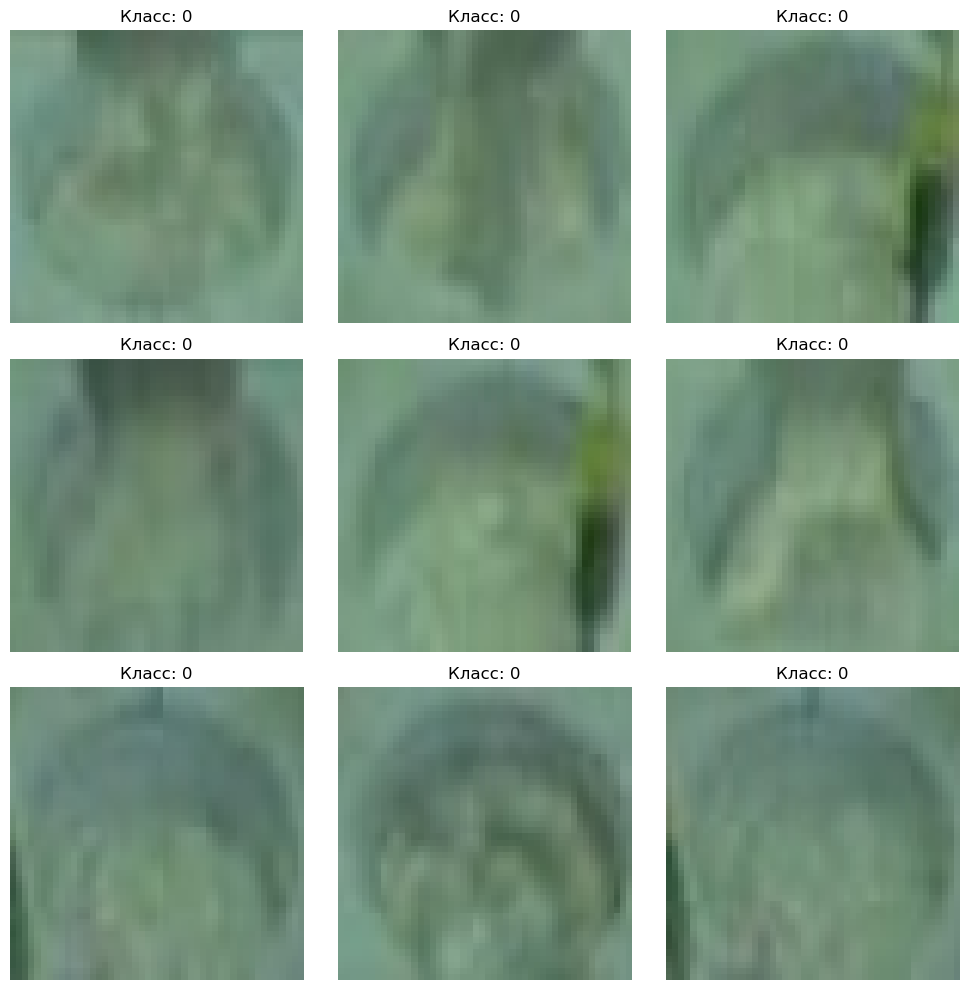

In [3]:
# Разделение данных на обучающую и тестовую выборки
train_paths, test_paths = train_test_split(img_paths, train_size=0.8, random_state=42)

# Функция загрузки и предобработки изображений
def preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [48, 48])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Размер батча
batch_size = 256

# Создание и подготовка обучающего датасета
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths).map(preprocess_image)
train_dataset_prepared = tf.data.Dataset.zip((train_dataset, train_dataset))
train_dataset_prepared = train_dataset_prepared.shuffle(500).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
print(f"Количество батчей в обучающем датасете: {len(train_dataset_prepared)}")

# Подготовка тестового датасета
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths).map(preprocess_image)
test_dataset_prepared = tf.data.Dataset.zip((test_dataset, test_dataset))
test_dataset_prepared = test_dataset_prepared.shuffle(500).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
print(f"Количество батчей в тестовом датасете: {len(test_dataset_prepared)}")

# Загрузка и подготовка тестовых данных
test_images_annotation = pd.read_csv("dataset/test/test_annotation.txt", sep=' ', names=['file_name', 'image_class'])
test_images_annotation['file_name'] = test_images_annotation['file_name'].apply(lambda x: f"dataset/test/imgs/{x}")
test_images_loaded = np.array([preprocess_image(filepath).numpy() for filepath in test_images_annotation['file_name'].tolist()])

# Вывод данных из тестового набора
def visualize_images(image_data, image_labels, rows=3, cols=3, figsize=(10, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < len(image_data):
            ax.imshow(image_data[i])
            ax.set_title(f"Класс: {image_labels.iloc[i]['image_class']}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_images(test_images_loaded, test_images_annotation)

In [4]:
def load_data(paths):
    data = []
    for path in paths:
        data.append(preprocess_image(path))
    return np.asarray(data)

def get_image_paths(folder):
    file_names = os.listdir(folder)
    file_paths = [os.path.join(folder, file_name) for file_name in file_names if file_name.endswith('.jpg')]
    return file_paths

folder_path = "dataset/proliv/"
proliv_paths = get_image_paths(folder_path)
print(f"Количество изображений: {len(proliv_paths)}")

data_proliv = load_data(proliv_paths)

Количество изображений: 154


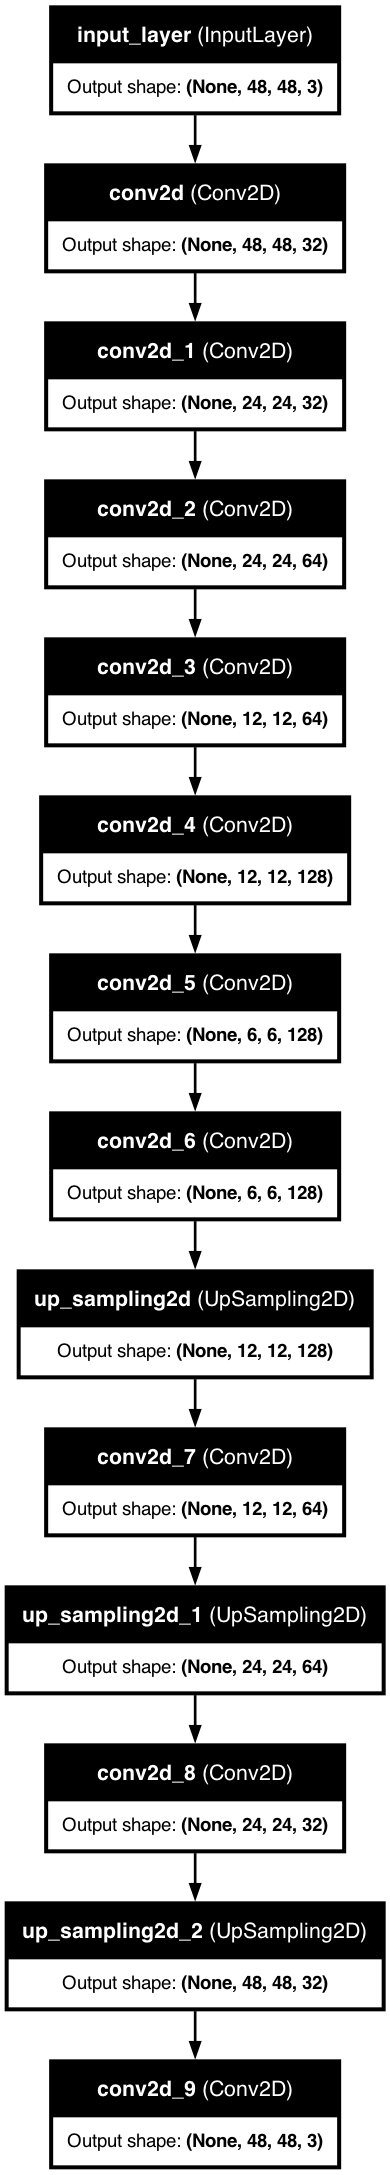

In [5]:
# Функция для создания сверточного блока
def conv_block(x, filters, kernel_size, strides=1, activation='relu', padding='same'):
    x = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation=activation)(x)
    return x

def create_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = conv_block(inputs, 32, (3, 3))
    x = conv_block(x, 32, (3, 3), strides=2)
    x = conv_block(x, 64, (3, 3))
    x = conv_block(x, 64, (3, 3), strides=2)
    x = conv_block(x, 128, (3, 3))
    x = conv_block(x, 128, (3, 3), strides=2)
    x = conv_block(x, 128, (3, 3))
    x = layers.UpSampling2D(2)(x)
    x = conv_block(x, 64, (3, 3))
    x = layers.UpSampling2D(2)(x)
    x = conv_block(x, 32, (3, 3))
    x = layers.UpSampling2D(2)(x)
    outputs = layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    return model

# Создание модели
model = create_model((48, 48, 3))

# Визуализация модели
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', dpi=96)

In [ ]:
# Компиляция модели
model.compile(optimizer="Adam", loss="mse")

# Обучение модели
hist = model.fit(
    train_dataset_prepared, 
    epochs=6, 
    validation_data=test_dataset_prepared, 
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs/exp')]
)

# Оценка модели
model.evaluate(test_dataset_prepared)

# График изменения функции потерь
history_df = pd.DataFrame(hist.history)
plt.figure(figsize=(10, 6))
plt.plot(history_df.index + 1, history_df['loss'], '-o', label='Потери на обучении', color='blue')
plt.plot(history_df.index + 1, history_df['val_loss'], '-o', label='Потери на валидации', color='red')
plt.title('Изменение функции потерь во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потери (MSE)')
plt.xticks(history_df.index + 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 0.0038 - val_loss: 0.0019
Epoch 2/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0019 - val_loss: 0.0019
Epoch 3/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/6
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/6
18/32 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 9.5494e-04

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

target_size = (48, 48)
n_images = 4
selected_images = train_paths[:n_images]
fig, axs = plt.subplots(n_images, 2, figsize=(10, 3 * n_images))

for i, img_path in enumerate(selected_images):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Добавление батч-размерности

    img_array = img_array / 255.0

    # Обработка изображения моделью
    res_img = model.predict(img_array)
    res_img = res_img * 255.0
    res_img = np.clip(res_img, 0, 255).astype('uint8')

    res_img_display = np.squeeze(res_img)

    # Отображение оригинального изображения
    axs[i, 0].imshow(img)
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')

    # Отображение обработанного изображения
    axs[i, 1].imshow(res_img_display)
    axs[i, 1].set_title('Processed Image')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from pathlib import Path

proliv_dir = Path("dataset/proliv")
proliv_paths = [path for path in proliv_dir.iterdir() if path.suffix == ".jpg"]
num_files = len(proliv_paths)
print(f"Найдено файлов: {num_files}")

In [ ]:
target_size = (48, 48)

n_images = 4
selected_paths = proliv_paths[:n_images]

fig, axs = plt.subplots(n_images, 2, figsize=(10, 3 * n_images))

for i, img_path in enumerate(selected_paths):
    orig_img = load_img(img_path)
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    img_array = img_array / 255.0

    # Обработка изображения моделью
    res_img = model.predict(img_array)
    res_img = res_img * 255.0
    res_img = np.clip(res_img, 0, 255).astype('uint8')

    res_img_display = np.squeeze(res_img)

    # Отображение оригинального изображения
    orig_img_resized = load_img(img_path, target_size=target_size)
    axs[i, 0].imshow(orig_img_resized)
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')

    # Отображение обработанного изображения
    axs[i, 1].imshow(res_img_display)
    axs[i, 1].set_title('Processed Image')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def load_data(paths, target_size=(48, 48)):
    data = []
    for path in paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        data.append(img_array)
    return np.array(data) / 255.0  # Нормализация данных

data_proliv = load_data(proliv_paths)
proliv_res = model.predict(data_proliv)

# Вычисление MSE для proliv
mse_list = np.mean(np.square(data_proliv - proliv_res), axis=(1,2,3))
mse = np.mean(mse_list)
print(f"MSE for proliv data: {mse}")

# Загрузка и обработка изображений с оригинальными путями
orig_imgs = load_data(img_paths[:1000])
orig_imgs_preds = model.predict(orig_imgs)

# Вычисление MSE для оригинальных изображений
mse_list_orig = np.mean(np.square(orig_imgs - orig_imgs_preds), axis=(1,2,3))
mse_orig = np.mean(mse_list_orig)
print(f"MSE for original images: {mse_orig}")

In [ ]:
orig_data = pd.DataFrame({
    'mse': mse_list_orig, 
    'class': ['Original' for _ in range(len(mse_list_orig))]
})

proliv_data = pd.DataFrame({
    'mse': mse_list, 
    'class': ['Proliv' for _ in range(len(mse_list))]
})

mse_data = pd.concat([orig_data, proliv_data], axis=0).reset_index(drop=True)
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='mse', data=mse_data)
plt.title('Сравнение MSE', fontsize=16)
plt.xlabel('Класс изображения', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image

# Дерево решений
model_tree = DecisionTreeClassifier(max_depth=1, criterion='entropy').fit(mse_data.drop(columns='class'), mse_data['class'])

dot_data = export_graphviz(model_tree, out_file=None, 
                           feature_names=['mse'],  
                           class_names=model_tree.classes_.astype(str), 
                           filled=True, rounded=True, 
                           special_characters=True)

dot_data = dot_data.replace('fillcolor="#e58139"', 'fillcolor="#00ff00"')

graph = graphviz.Source(dot_data)
png_bytes = graph.pipe(format='png')

Image(png_bytes)

In [ ]:
# Предсказание модели
preds = model.predict(test_images_loaded)

# Определение порогового значения
threshold = 0.213 / 100

def compute_mse_threshold(imgs, preds, threshold=0.1):
    labels = [1 if np.mean(np.square(img - pred)) >= threshold else 0 for img, pred in zip(imgs, preds)]
    return np.array(labels)

def print_metrics(true_labels, predicted_labels, threshold):
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    print(f"TPR = {tp/(tp+fn)}, FPR = {tn/(tn+fp)}, MSE_threshold = {threshold}")

# Вычисление предсказанных меток с заданным порогом
predicted_labels = compute_mse_threshold(test_images_loaded, preds, threshold=threshold)
print_metrics(test_images_annotation['image_class'], predicted_labels, threshold)
test_images_annotation['predicted'] = predicted_labels

# Повторное вычисление и печать метрик для проверки
print_metrics(test_images_annotation['image_class'], test_images_annotation['predicted'], threshold)

model.save("model.keras")